In [ ]:
!apt-get install -qq libproj-dev proj-data proj-bin
!apt-get install -qq libgeos-dev
!pip install shapely --no-binary shapely
!pip install cartopy
!pip install python-louvain


Selecting previously unselected package proj-bin.
(Reading database ... 131015 files and directories currently installed.)
Preparing to unpack .../proj-bin_8.2.1-1_amd64.deb ...
Unpacking proj-bin (8.2.1-1) ...
Setting up proj-bin (8.2.1-1) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 21.2 MB/s eta 0:00:00


In [ ]:
# import libraries
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import collections
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
import math

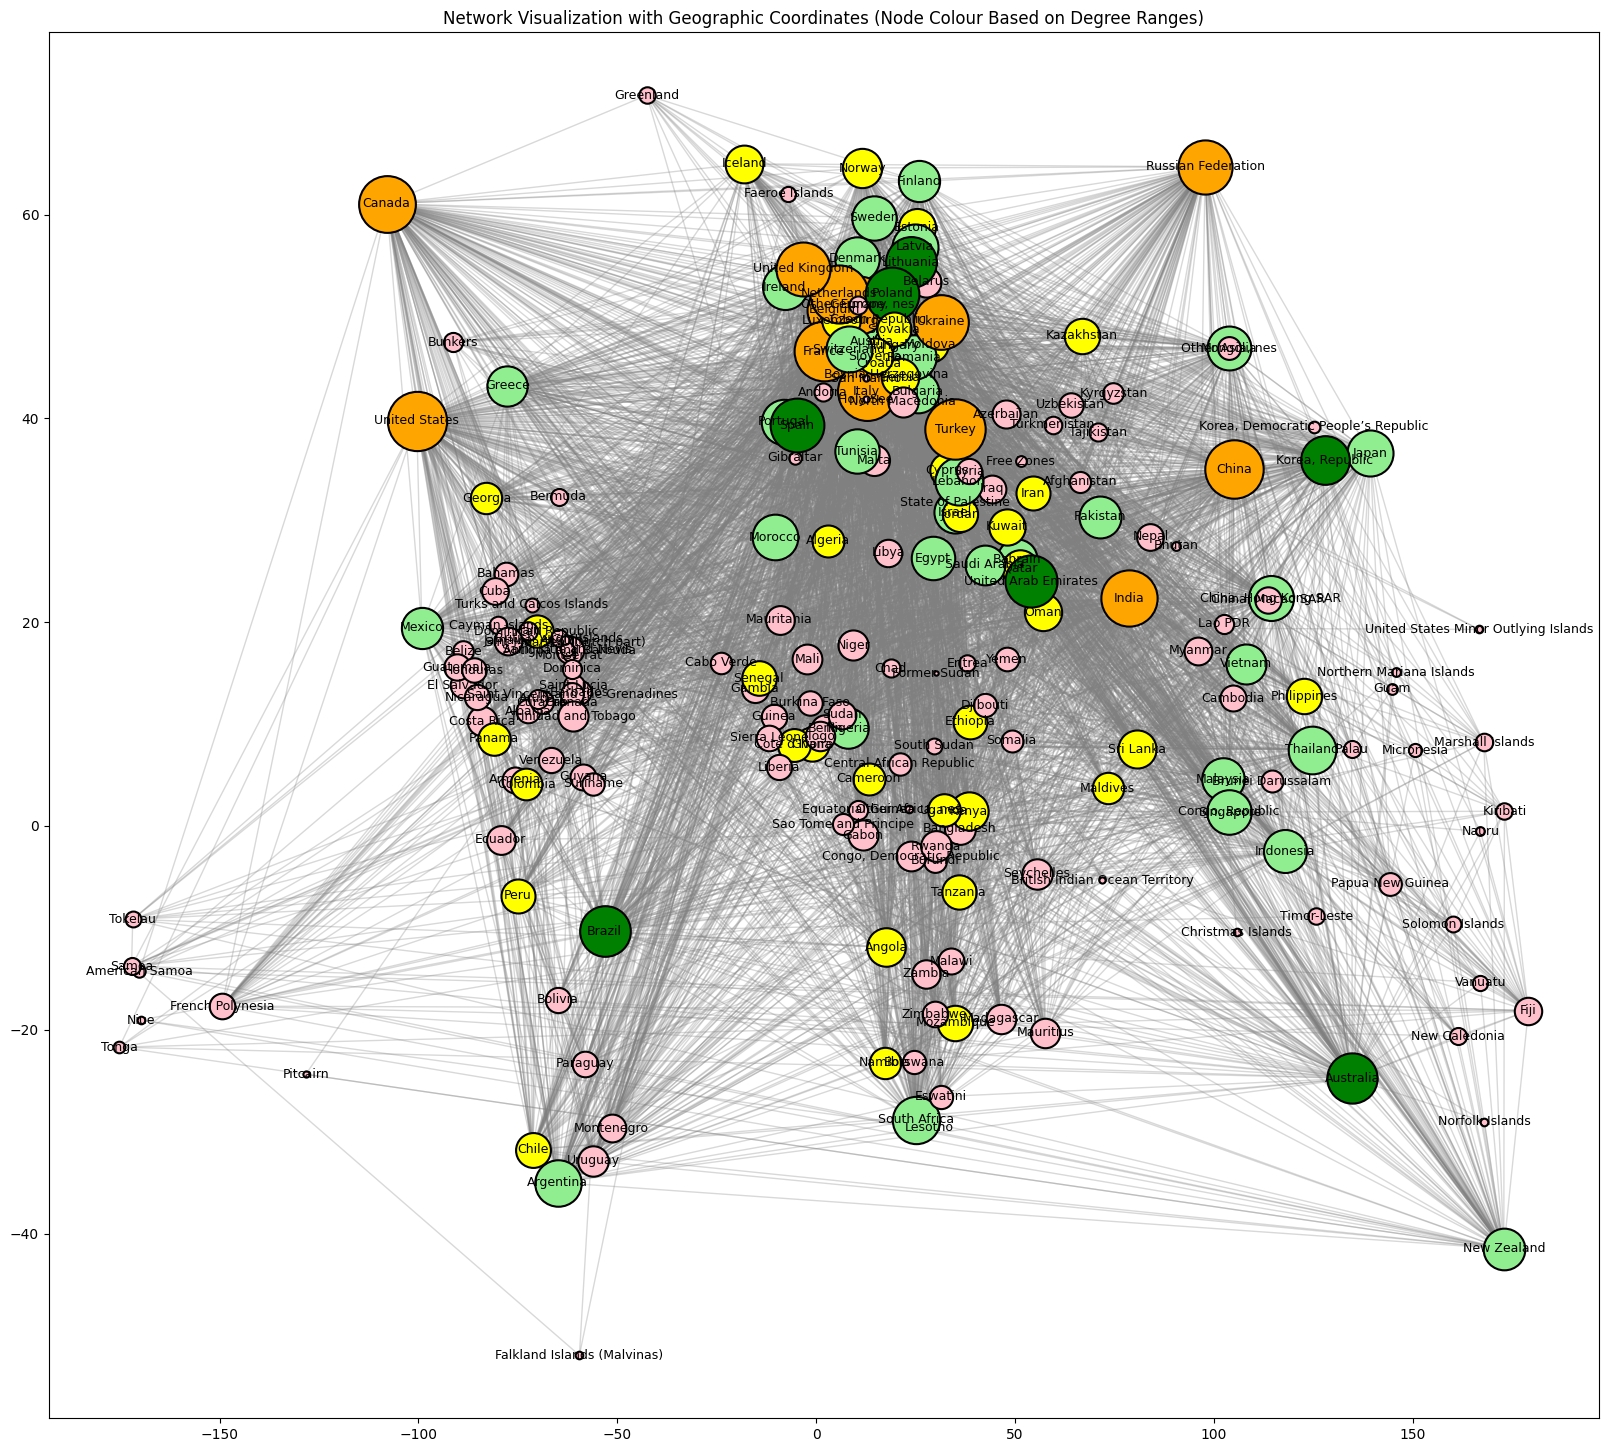

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from CSV files
nodes_df = pd.read_csv('/content/wheet_lat_world.csv')
edges_df = pd.read_csv('/content/data_wheat_world.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    G.add_node(row['Source'], pos=(row['Latitude'], row['Longitude']))

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Calculate node degrees
node_degrees = dict(G.degree())

# Determine nodes to label (degree > 35)
label_nodes = [node for node, degree in node_degrees.items() if degree > 0]

# Draw the network
plt.figure(figsize=(20, 18))

# Draw edges with reduced alpha for clarity
for edge in G.edges():
    u, v = edge
    if u in pos and v in pos:  # Check if both nodes have positions
        y1, x1 = pos[u]  # Swap x and y coordinates
        y2, x2 = pos[v]  # Swap x and y coordinates
        plt.plot([x1, x2], [y1, y2], 'gray', alpha=0.3, linewidth=1)  # Reduce alpha for clarity

# Draw nodes with positions, sizes according to degree, and colours based on degree ranges
for node, position in pos.items():
    y, x = position  # Swap x and y coordinates
    node_degree = node_degrees[node]
    node_size = node_degree * 10  # Adjust the multiplier for desired node size
    if node_degree <= 50:
        node_color = 'pink'
    elif node_degree <= 80:
        node_color = 'yellow'
    elif node_degree <= 120:
        node_color = 'lightgreen'
    elif node_degree <= 150:
        node_color = 'green'
    else:
        node_color = 'orange'
    if node in label_nodes:
        plt.scatter(x, y, s=node_size, c=node_color, edgecolors='black', linewidths=1.5, zorder=2)  # Ensure labelled nodes are on top
        plt.text(x, y, node, fontsize=9, ha='center', va='center', zorder=3)  # Add node label
    else:
        plt.scatter(x, y, s=node_size, c=node_color, zorder=1)

plt.title('Network Visualization with Geographic Coordinates (Node Colour Based on Degree Ranges)')
plt.show()


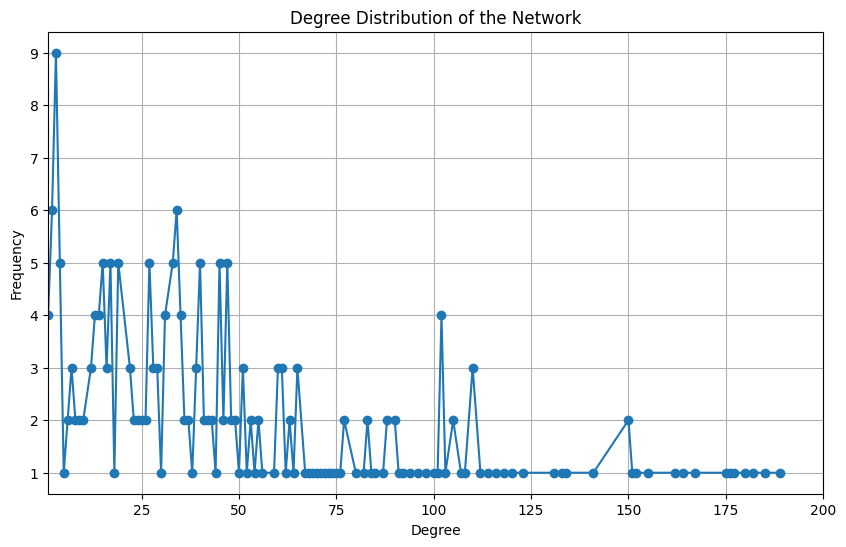

In [ ]:
import numpy as np

# Calculate the degrees of all nodes
degrees = [degree for node, degree in nx.degree(G)]

# Calculate the frequency of each degree value
degree_values = np.unique(degrees)
degree_counts = [degrees.count(x) for x in degree_values]

# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.plot(degree_values, degree_counts, 'o-') # 'o-' creates a line plot with circle markers
plt.xlabel('Degree')
plt.xlim([1,200])
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Network')
plt.grid(True)
plt.show()


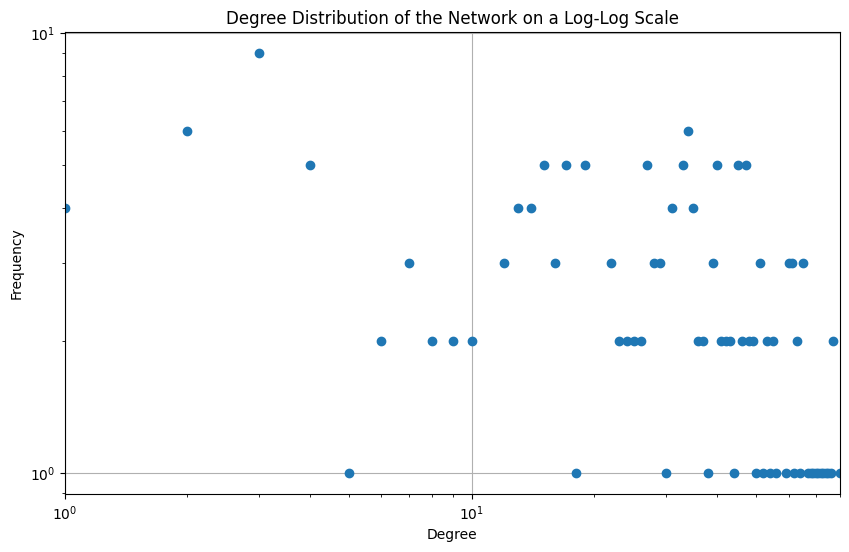

In [ ]:
# Plot the degree distribution on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(degree_values, degree_counts, 'o') # 'o-' creates a line plot with circle markers on a log-log scale
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Network on a Log-Log Scale')
plt.grid(True)
plt.xlim([1, 80]) # Set the limit for the x-axis
plt.show()


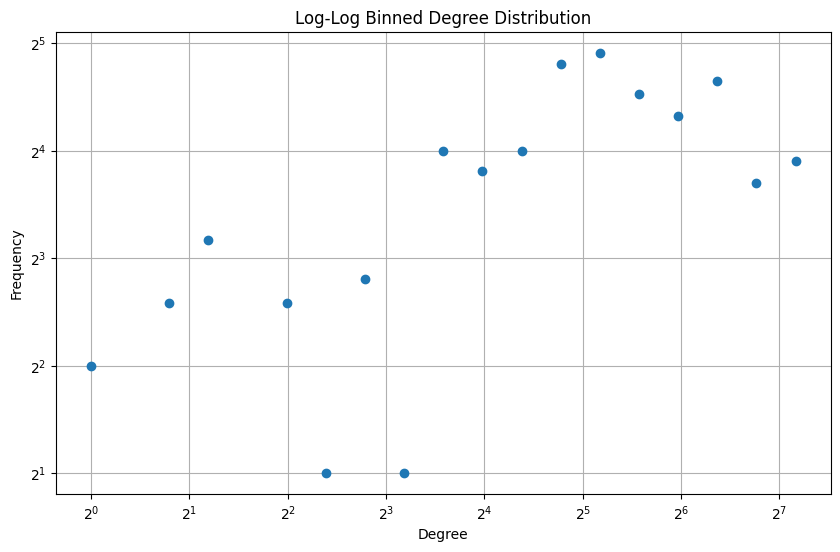

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import collections  # Import the collections module

# Function to perform log binning
def log_binning(counter_dict, bin_count=10):
    max_exponent = np.log2(max(counter_dict.keys()))
    max_value = 2**max_exponent
    bins = np.logspace(0, max_exponent, num=bin_count, base=2)
    binned_counts = np.histogram(list(counter_dict.keys()), bins=bins, weights=list(counter_dict.values()))[0]
    binned_degrees = np.histogram(list(counter_dict.keys()), bins=bins)[1]
    return binned_degrees[:-1], binned_counts

# Calculate the degree of each node
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

# Perform log binning
binned_deg, binned_cnt = log_binning(degree_count, bin_count=20)

# Plot the degree distribution after log binning on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(binned_deg, binned_cnt, 'o', base=2)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Log-Log Binned Degree Distribution')
plt.grid(True)
plt.show()


Estimated power-law exponent (alpha): 1.3994846063008477
Standard error of the exponent estimate (sigma): 0.026573320730611773


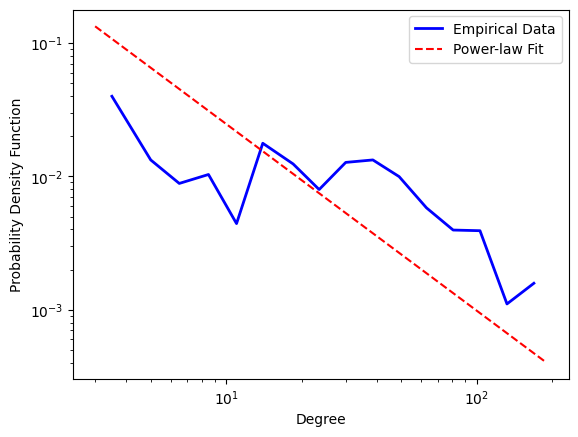

Loglikelihood ratio (R) comparing power law and exponential distributions: -11.041094823795095
p-value of the likelihood ratio test: 2.4206553878566917e-28
The power-law distribution is a significantly better fit than the exponential distribution.


In [ ]:
!pip install powerlaw
import powerlaw
import networkx as nx
import matplotlib.pyplot as plt

# Assuming G is your networkx graph
degrees = [degree for node, degree in G.degree() if degree > 0]  # Exclude nodes with degree 0

# Fit the degree distribution to a power-law distribution
fit = powerlaw.Fit(degrees, xmin=3)
alpha = fit.power_law.alpha
sigma = fit.power_law.sigma

print(f"Estimated power-law exponent (alpha): {alpha}")
print(f"Standard error of the exponent estimate (sigma): {sigma}")

# Plot the degree distribution and the power-law fit
fig = fit.plot_pdf(color='b', linewidth=2, label='Empirical Data')
fit.power_law.plot_pdf(color='r', linestyle='--', label='Power-law Fit')
plt.xlabel('Degree')
plt.ylabel('Probability Density Function')
plt.legend(loc='upper right')
plt.show()

# Calculate the goodness of fit
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print(f"Loglikelihood ratio (R) comparing power law and exponential distributions: {R}")
print(f"p-value of the likelihood ratio test: {p}")

# Interpretation of results
if p < 0.05:
    print("The power-law distribution is a significantly better fit than the exponential distribution.")
else:
    print("There is not enough evidence to conclude that the power-law distribution is a better fit than the exponential distribution.")


In [ ]:
r = nx.degree_pearson_correlation_coefficient(G)
print(f"{r:3.15f}")


-0.317887999419582


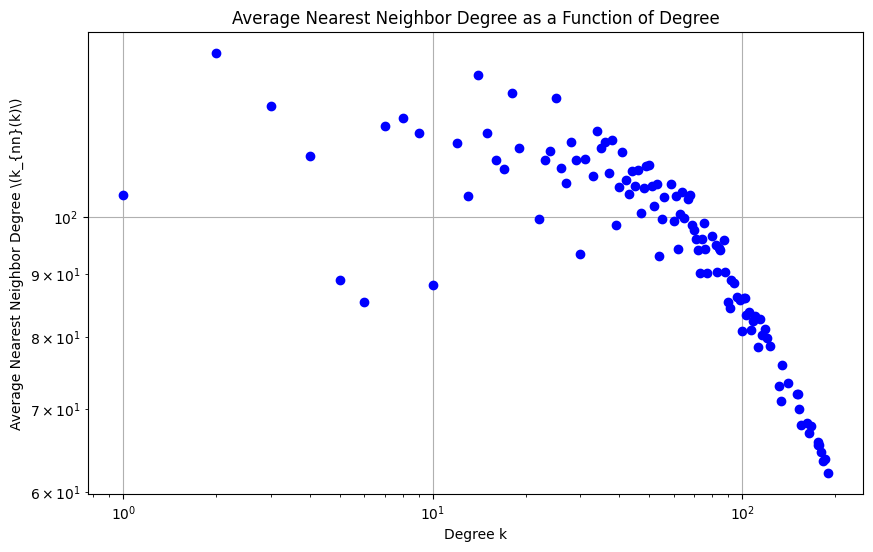

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Assuming G is your networkx graph

# Calculate the degree of each node
degrees = dict(G.degree())
k_values = np.array(list(degrees.values()))
unique_k = np.unique(k_values)

# Calculate k_nn for each node
k_nn = {node: np.mean([degrees[n] for n in G.neighbors(node)]) if len(list(G.neighbors(node))) > 0 else 0 for node in G.nodes()}

# Aggregate k_nn by k
k_nn_k = [np.mean([k_nn[node] for node in G.nodes() if degrees[node] == k]) for k in unique_k]

# Plot k_nn(k) versus k on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(unique_k, k_nn_k, 'bo')
plt.xlabel('Degree k')
plt.ylabel('Average Nearest Neighbor Degree \(k_{nn}(k)\)')
plt.title('Average Nearest Neighbor Degree as a Function of Degree')
plt.grid(True)
plt.show()


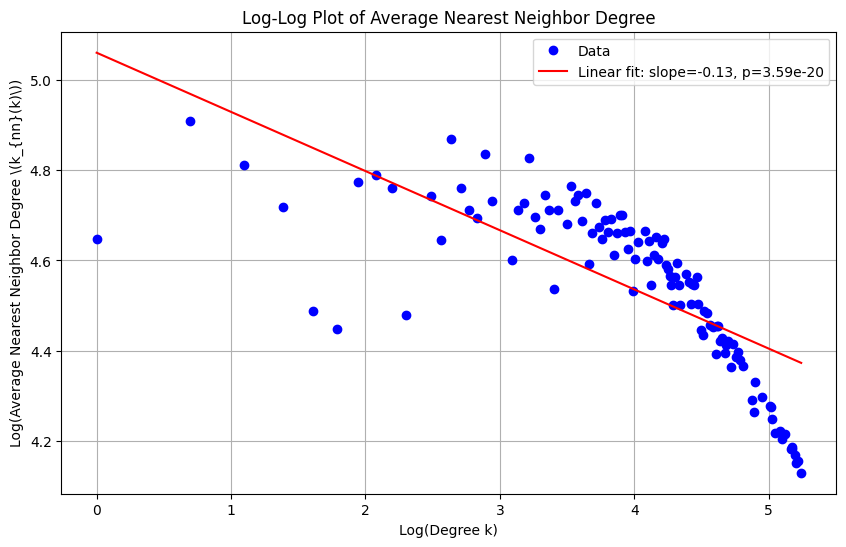

Slope of the linear regression line: -0.13
P-value for testing the null hypothesis that the slope is zero: 3.59e-20


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Ensure k_nn_k is a NumPy array
unique_k = np.array(unique_k)
k_nn_k = np.array(k_nn_k)

# Filter out zero values to avoid log(0)
non_zero_indices = (unique_k > 0) & (k_nn_k > 0)
log_k = np.log(unique_k[non_zero_indices])
log_k_nn_k = np.log(k_nn_k[non_zero_indices])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(log_k, log_k_nn_k)

# Plot the original data and the linear regression line
plt.figure(figsize=(10, 6))
plt.plot(log_k, log_k_nn_k, 'bo', label='Data')
plt.plot(log_k, intercept + slope*log_k, 'r-', label=f'Linear fit: slope={slope:.2f}, p={p_value:.2e}')
plt.xlabel('Log(Degree k)')
plt.ylabel('Log(Average Nearest Neighbor Degree \(k_{nn}(k)\))')
plt.title('Log-Log Plot of Average Nearest Neighbor Degree')
plt.legend()
plt.grid(True)
plt.show()

# Print the slope and its significance
print(f"Slope of the linear regression line: {slope:.2f}")
print(f"P-value for testing the null hypothesis that the slope is zero: {p_value:.2e}")


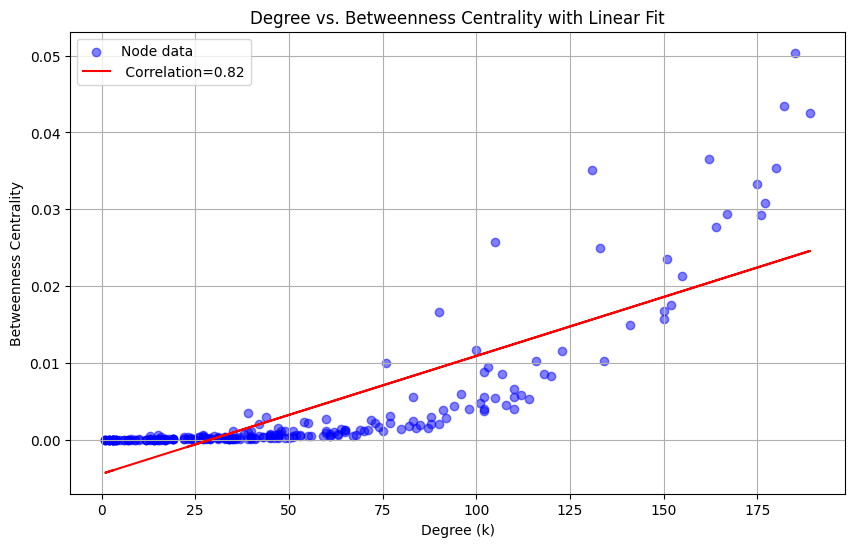

Slope: 0.00
Pearson correlation coefficient: 0.82
P-value: 1.43e-57


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats
import numpy as np

# Calculate node degree and betweenness centrality
node_degrees = np.array([degree for node, degree in G.degree()])
betweenness_values = np.array([value for node, value in nx.betweenness_centrality(G).items()])

# Calculate the Pearson correlation coefficient
correlation_coefficient, _ = stats.pearsonr(node_degrees, betweenness_values)

# Perform linear regression to get the line of best fit
slope, intercept, _, p_value, _ = stats.linregress(node_degrees, betweenness_values)

# Generate regression line values
line_values = slope * node_degrees + intercept

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(node_degrees, betweenness_values, color='blue', alpha=0.5, label='Node data')
plt.plot(node_degrees, line_values, 'r-', label=f' Correlation={correlation_coefficient:.2f}')
plt.xlabel('Degree (k)')
plt.ylabel('Betweenness Centrality')
plt.title('Degree vs. Betweenness Centrality with Linear Fit')
plt.legend()
plt.grid(True)
plt.show()

# Print the slope, correlation coefficient, and p-value
print(f"Slope: {slope:.2f}")
print(f"Pearson correlation coefficient: {correlation_coefficient:.2f}")
print(f"P-value: {p_value:.2e}")


In [ ]:
import csv

# Dictionary containing country names as keys and their latitude and longitude as values
countries_data = {
    "Albania": (41.1533, 20.1683),
    "Austria": (47.5162, 14.5501),
    "Belgium": (50.5039, 4.4699),
    "Bosnia Herzegovina": (43.9159, 17.6791),
    "Bulgaria": (42.7339, 25.4858),
    "Belarus": (53.7098, 27.9534),
    "Croatia": (45.1, 15.2),
    "Czech Republic": (49.8175, 15.473),
    "Denmark": (56.2639, 9.5018),
    "Estonia": (58.5953, 25.0136),
    "Faeroe Islands": (61.8926, 6.9118),
    "Finland": (61.9241, 25.7482),
    "France": (46.6034, 1.8883),
    "Germany": (51.1657, 10.4515),
    "Greece": (39.0742, 21.8243),
    "Hungary": (47.1625, 19.5033),
    "Iceland": (64.9631, -19.0208),
    "Ireland": (53.1424, -7.6921),
    "Italy": (41.8719, 12.5674),
    "Latvia": (56.8796, 24.6032),
    "Lithuania": (55.1694, 23.8813),
    "Luxembourg": (49.8153, 6.1296),
    "Malta": (35.9375, 14.3754),
    "Moldova": (47.4116, 28.3699),
    "Montenegro": (42.7087, 19.3744),
    "Netherlands": (52.1326, 5.2913),
    "Norway": (60.472, 8.4689),
    "Poland": (51.9194, 19.1451),
    "Portugal": (39.3999, -8.2245),
    "Romania": (45.9432, 24.9668),
    "Russian Federation": (61.524, 105.3188),
    "San Marino": (43.9424, 12.4578),
    "Serbia": (44.0165, 21.0059),
    "Slovakia": (48.669, 19.699),
    "Slovenia": (46.1512, 14.9955),
    "Spain": (40.4637, -3.7492),
    "Sweden": (60.1282, 18.6435),
    "Switzerland": (46.8182, 8.2275),
    "Ukraine": (48.3794, 31.1656),
    "North Macedonia": (41.6086, 21.7453),
    "United Kingdom": (55.3781, -3.436),
    "Andorra": (42.5463, 1.6016),
    "Holy See": (41.9029, 12.4534)
}

# Writing data to CSV file
with open('countries_coordinates.csv', 'w', newline='') as csvfile:
    fieldnames = ['Country', 'Latitude', 'Longitude']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for country, (lat, lon) in countries_data.items():
        writer.writerow({'Country': country, 'Latitude': lat, 'Longitude': lon})

print("CSV file generated successfully.")


CSV file generated successfully.


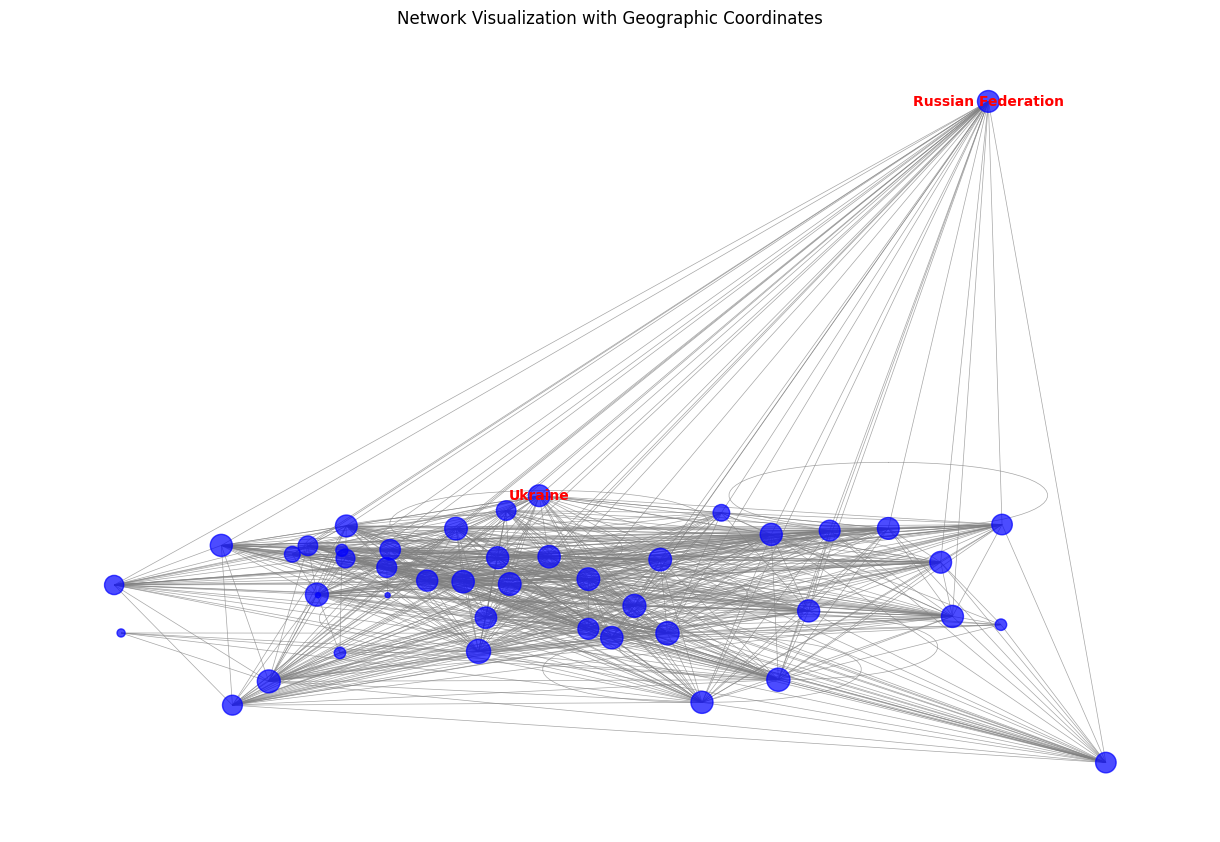

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from CSV files
nodes_df = pd.read_csv('/content/countries_coordinates.csv')
edges_df = pd.read_csv('/content/wheet_2022.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    G.add_node(row['Source'], pos=(row['Latitude'], row['Longitude']))

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Calculate node sizes based on degree
node_degrees = dict(G.degree())
max_degree = max(node_degrees.values())
node_sizes = [300 * (node_degrees[node] / max_degree) for node in G.nodes()]

# Define colors for the nodes
node_colors = ['blue' for _ in G.nodes()]

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(G, pos, node_size=node_sizes, node_color=node_colors, width=0.5, with_labels=False, edge_color='gray', alpha=0.7)

# Add labels to Russia and Ukraine nodes
labels = {}
for node, (x, y) in pos.items():
    if node in ['Russian Federation', 'Ukraine']:
        labels[node] = node

nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='red', font_weight='bold')

plt.title('Network Visualization with Geographic Coordinates')
plt.show()


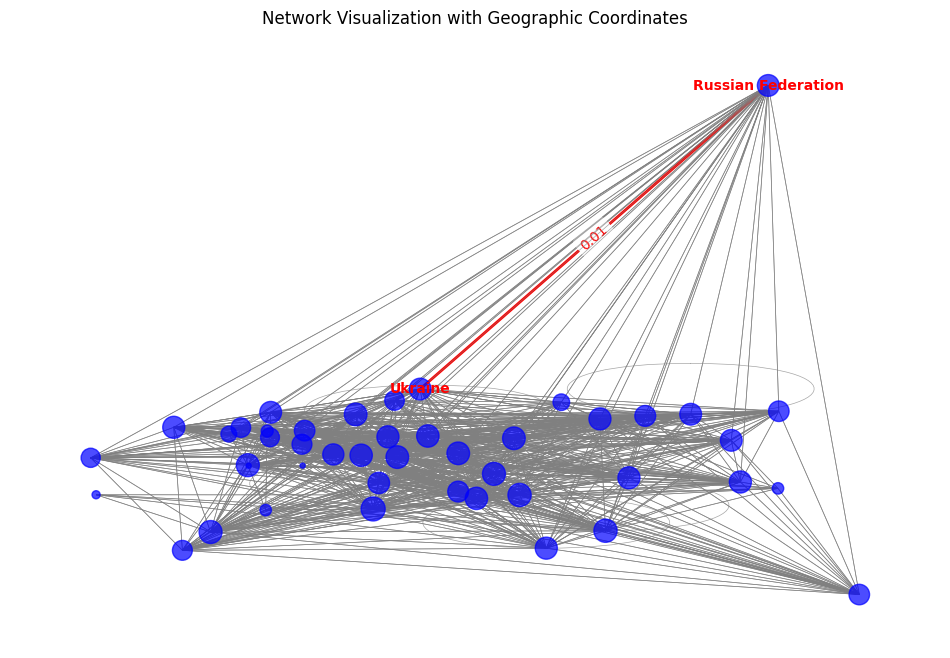

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from CSV files
nodes_df = pd.read_csv('/content/countries_coordinates.csv')
edges_df = pd.read_csv('/content/wheet_2022.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    G.add_node(row['Source'], pos=(row['Latitude'], row['Longitude']))

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Calculate node sizes based on degree
node_degrees = dict(G.degree())
max_degree = max(node_degrees.values())
node_sizes = [300 * (node_degrees[node] / max_degree) for node in G.nodes()]

# Define colors for the nodes
node_colors = ['blue' for _ in G.nodes()]

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Draw the network
plt.figure(figsize=(12, 8))

# Draw edges with different attributes for edges between Russia and Ukraine
for edge in G.edges():
    if ('Russian Federation' in edge and 'Ukraine' in edge) or ('Ukraine' in edge and 'Russian Federation' in edge):
        weight = G[edge[0]][edge[1]]['weight']
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=2, edge_color='red')
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(edge[0], edge[1]): f'{weight:.2f}'}, font_color='red')
    else:
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=0.5, edge_color='gray')

nx.draw(G, pos, node_size=node_sizes, node_color=node_colors, width=0.5, with_labels=False, edge_color='gray', alpha=0.7)

# Add labels to Russia and Ukraine nodes
labels = {}
for node, (x, y) in pos.items():
    if node in ['Russian Federation', 'Ukraine']:
        labels[node] = node

nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='red', font_weight='bold')

plt.title('Network Visualization with Geographic Coordinates')
plt.show()


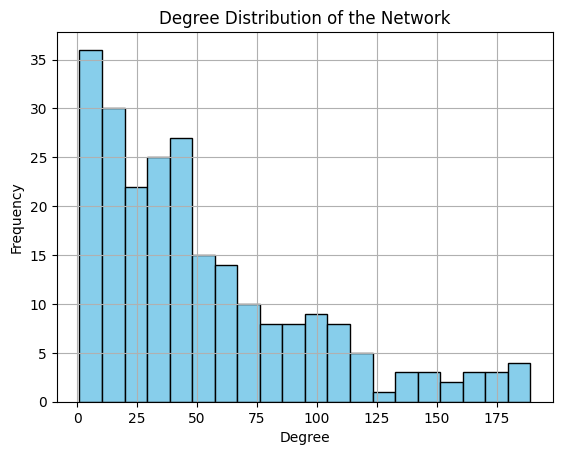

In [ ]:
# Calculate node degrees
node_degrees = dict(G.degree())

# Plot degree distribution
plt.hist(node_degrees.values(), bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Network')
plt.grid(True)
plt.show()


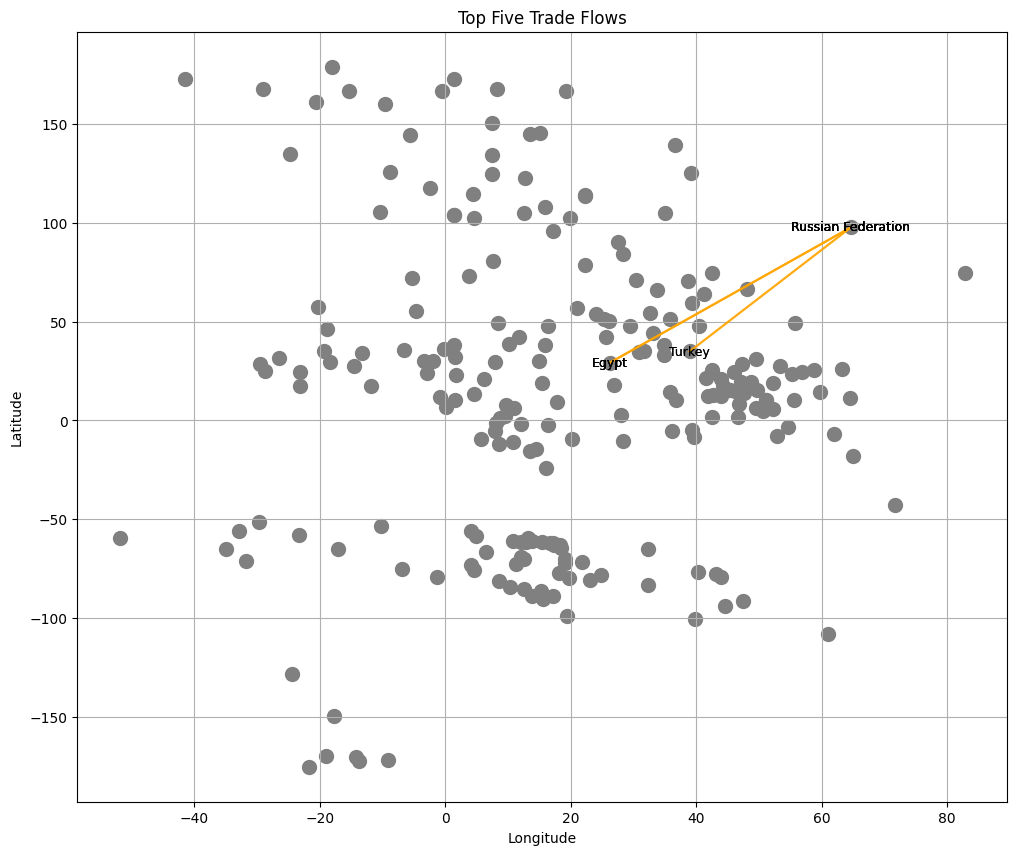

In [ ]:
# Find the top five trade flows
top_five_flows = edges_df.nlargest(5, 'Weight ')

# Plot the network
plt.figure(figsize=(12, 10))

# Draw edges for top five trade flows
for index, row in top_five_flows.iterrows():
    source = row['Source']
    target = row['Target']
    plt.plot([pos[source][0], pos[target][0]], [pos[source][1], pos[target][1]], color='orange', alpha=0.7)

# Draw nodes
for node, position in pos.items():
    plt.scatter(position[0], position[1], s=100, c='gray')

# Draw labels for top five trade flows
for index, row in top_five_flows.iterrows():
    plt.text(pos[row['Source']][0], pos[row['Source']][1], row['Source'], fontsize=9, ha='center', va='center')
    plt.text(pos[row['Target']][0], pos[row['Target']][1], row['Target'], fontsize=9, ha='center', va='center')

plt.title('Top Five Trade Flows')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


<ipython-input-27-b37de6cf0f63>:33: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


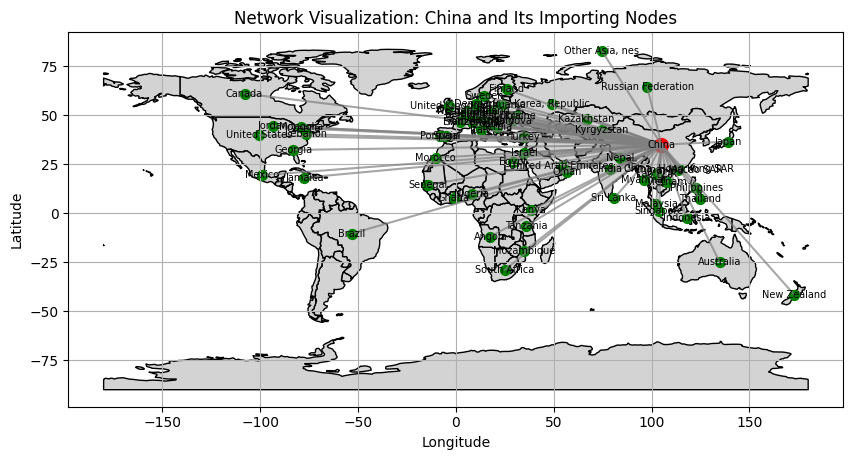

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Read the data from CSV files
nodes_df = pd.read_csv('/content/wheet_lat_world.csv')
edges_df = pd.read_csv('/content/data_wheat_world.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    G.add_node(row['Source'], pos=(row['Latitude'], row['Longitude']))

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    # Only add edges where China is the target (importing)
    if row['Target'] == 'China':
        G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Get the subgraph consisting only of China and its directly connected nodes
china_subgraph = nx.ego_graph(G, 'China', radius=1, center=True, undirected=False)

# Plot the network
plt.figure(figsize=(10, 12))  # Adjust figure size for the rotated plot

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot world map
world.plot(ax=plt.gca(), color='lightgray', edgecolor='black')

# Draw edges between China and its directly connected nodes
for node in china_subgraph.nodes():
    if node != 'China' and node in pos:  # Check if the node exists in pos
        plt.plot([pos[node][1], pos['China'][1]], [pos[node][0], pos['China'][0]], color='gray', alpha=0.7)

# Draw nodes
for node, position in pos.items():
    if node in china_subgraph.nodes() and node in pos:  # Check if the node exists in china_subgraph and pos
        if node == 'China':
            plt.scatter(position[1], position[0], s=100, c='red', label='_')  # Don't show China in the legend
            plt.text(position[1], position[0], node, fontsize=7, ha='center', va='center')  # Label China with smaller font size
        else:
            plt.scatter(position[1], position[0], s=50, c='green', label='_')  # Don't show directly connected nodes in the legend
            plt.text(position[1], position[0], node, fontsize=7, ha='center', va='center')  # Label directly connected nodes with smaller font size

plt.title('Network Visualization: China and Its Importing Nodes')
plt.show()


<ipython-input-43-14901d23bcda>:34: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


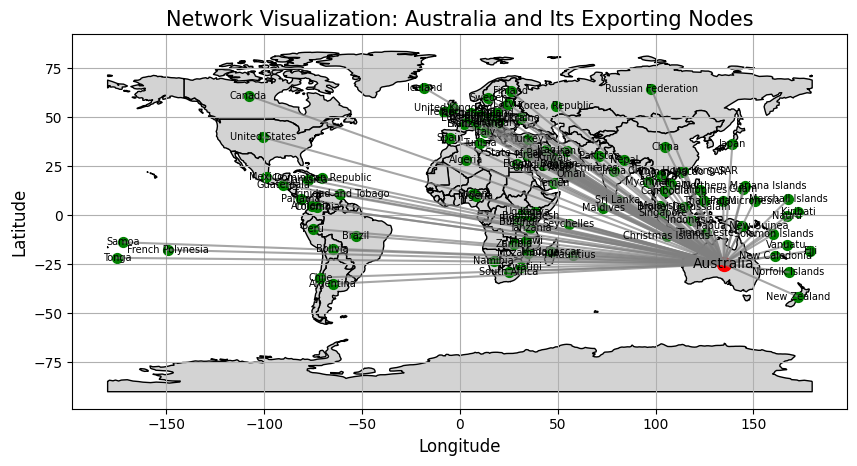

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Read the data from CSV files
nodes_df = pd.read_csv('/content/wheet_lat_world.csv')
edges_df = pd.read_csv('/content/data_wheat_world.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    if row['Source'] not in ['Georgia', 'Other Asia, nes', 'Georgia', 'Lebanon', 'Mongolia', 'Jordan']:  # Exclude specified nodes
        G.add_node(row['Source'], pos=(row['Latitude'], row['Longitude']))

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    # Only add edges where Australia is the source (exporting)
    if row['Source'] == 'Australia':
        G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Get the subgraph consisting only of Australia and its directly connected nodes
australia_subgraph = nx.ego_graph(G, 'Australia', radius=1, center=True, undirected=False)

# Plot the network
plt.figure(figsize=(10, 12))  # Adjust figure size for the rotated plot

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot world map
world.plot(ax=plt.gca(), color='lightgray', edgecolor='black')

# Draw edges between Australia and its directly connected nodes
for node in australia_subgraph.nodes():
    if node != 'Australia' and node in pos:  # Check if the node exists in pos
        plt.plot([pos['Australia'][1], pos[node][1]], [pos['Australia'][0], pos[node][0]], color='gray', alpha=0.7)

# Draw nodes
for node, position in pos.items():
    if node in australia_subgraph.nodes() and node in pos:  # Check if the node exists in australia_subgraph and pos
        if node == 'Australia':
            plt.scatter(position[1], position[0], s=100, c='red', label='_')  # Don't show Australia in the legend
            plt.text(position[1], position[0], node, fontsize=10, ha='center', va='center', fontname='Times New Roman', color='black')  # Label Australia with Times New Roman font
        else:
            plt.scatter(position[1], position[0], s=50, c='green', label='_')  # Don't show directly connected nodes in the legend
            plt.text(position[1], position[0], node, fontsize=7, ha='center', va='center', fontname='Times New Roman', color='black')  # Label directly connected nodes with Times New Roman font

plt.title('Network Visualization: Australia and Its Exporting Nodes', fontname='Times New Roman', fontsize=15)
plt.xlabel('Longitude', fontname='Times New Roman', fontsize=12)  # Swap x and y labels
plt.ylabel('Latitude', fontname='Times New Roman', fontsize=12)  # Swap x and y labels
plt.grid(True)
plt.show()


<ipython-input-2-0774cd0d6ad5>:35: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


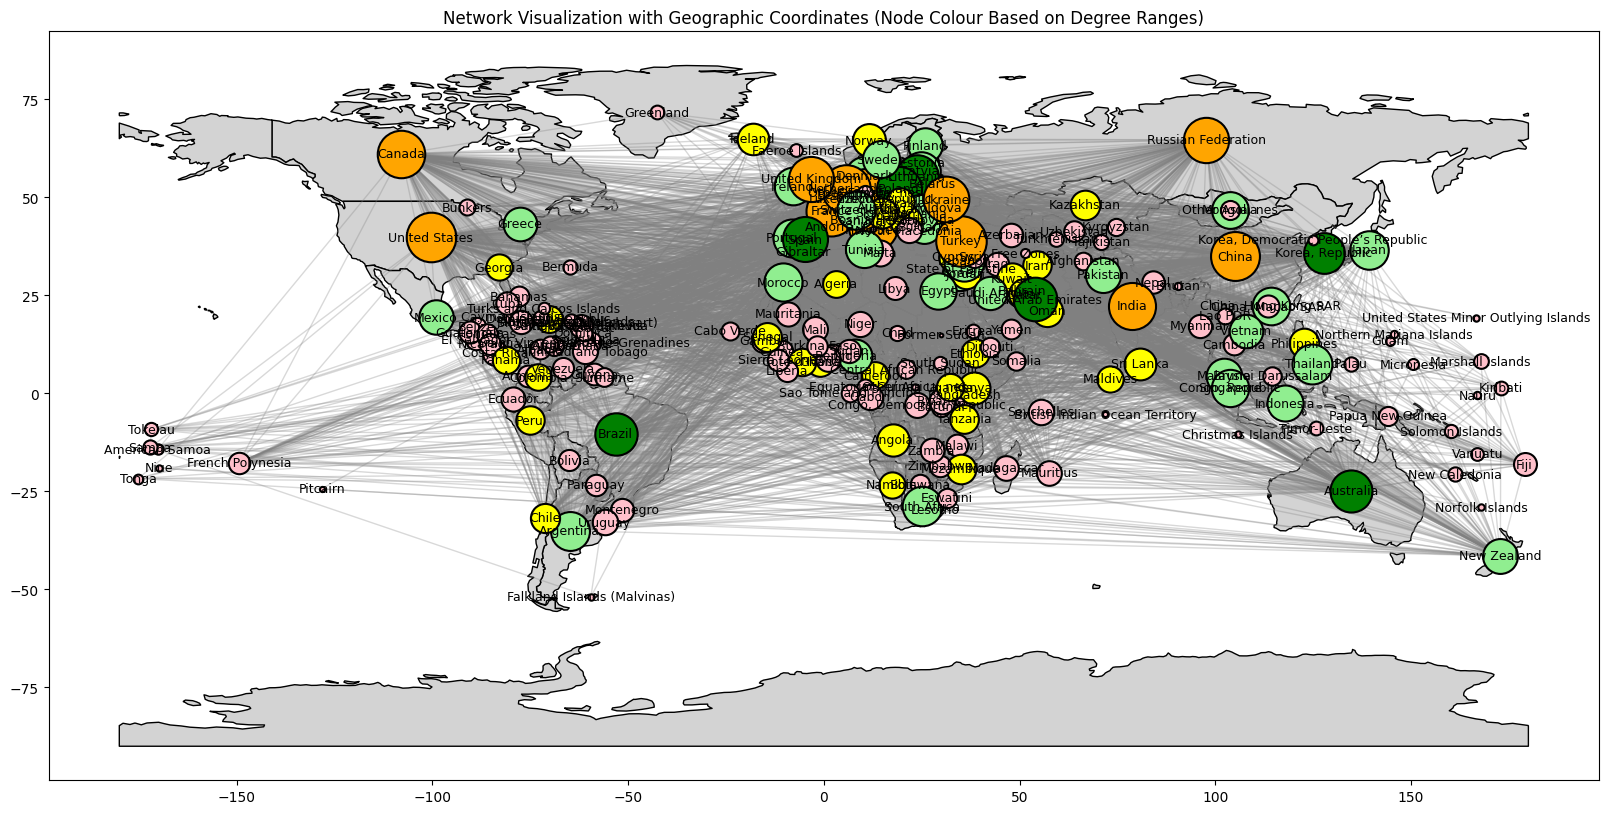

Community 1: frozenset({'Marshall Islands', 'Suriname', 'Oceania, nes', 'Guatemala', 'Canada', 'Papua New Guinea', 'Saint Pierre and Miquelon', 'Gibraltar', 'Paraguay', 'Lao PDR', 'Brunei Darussalam', 'Myanmar', 'Mauritius', 'Cook Islands', 'British Virgin Islands', 'Guinea-Bissau', 'Bahamas', 'Cayman Islands', 'Mozambique', 'Belize', 'Korea, Democratic People’s Republic', 'Guam', 'Djibouti', 'Panama', 'Argentina', 'Timor-Leste', 'Jamaica', 'Guyana', 'Fiji', 'Cocos Islands', 'United States Minor Outlying Islands', 'Burundi', 'Peru', 'Saint Kitts and Nevis', 'United States', 'Nicaragua', 'Nepal', 'New Zealand', 'China', 'Samoa', 'Italy', 'American Samoa', 'Barbados', 'Tuvalu', 'Grenada', 'Namibia', 'Haiti', 'China, Hong Kong SAR', 'Norfolk Islands', 'Vanuatu', 'Germany', 'Holy See', 'Dominican Republic', 'Curacao', 'Cambodia', 'Costa Rica', 'India', 'Palau', 'Sint Maarten (Dutch part)', 'Mongolia', 'Antigua and Barbuda', 'Montserrat', 'Dominica', 'Kiribati', 'Colombia', 'Malawi', 'El Sa

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms import community
import geopandas as gpd

# Read the data from CSV files
nodes_df = pd.read_csv('/content/wheet_lat_world.csv')
edges_df = pd.read_csv('/content/data_wheat_world.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    G.add_node(row['Source'], pos=(row['Latitude'], row['Longitude']))

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Calculate node degrees
node_degrees = dict(G.degree())

# Determine nodes to label (degree > 35)
label_nodes = [node for node, degree in node_degrees.items() if degree > 0]

# Plot the network with a world map background
plt.figure(figsize=(20, 18))

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot world map
world.plot(ax=plt.gca(), color='lightgray', edgecolor='black')

# Draw edges with reduced alpha for clarity
for edge in G.edges():
    u, v = edge
    if u in pos and v in pos:  # Check if both nodes have positions
        y1, x1 = pos[u]  # Swap x and y coordinates
        y2, x2 = pos[v]  # Swap x and y coordinates
        plt.plot([x1, x2], [y1, y2], 'gray', alpha=0.3, linewidth=1)  # Reduce alpha for clarity

# Draw nodes with positions, sizes according to degree, and colours based on degree ranges
for node, position in pos.items():
    y, x = position  # Swap x and y coordinates
    node_degree = node_degrees[node]
    node_size = node_degree * 7  # Adjust the multiplier for desired node size
    if node_degree <= 50:
        node_color = 'pink'
    elif node_degree <= 80:
        node_color = 'yellow'
    elif node_degree <= 120:
        node_color = 'lightgreen'
    elif node_degree <= 150:
        node_color = 'green'
    else:
        node_color = 'orange'
    if node in label_nodes:
        plt.scatter(x, y, s=node_size, c=node_color, edgecolors='black', linewidths=1.5, zorder=2)  # Ensure labelled nodes are on top
        plt.text(x, y, node, fontsize=9, ha='center', va='center', zorder=3)  # Add node label
    else:
        plt.scatter(x, y, s=node_size, c=node_color, zorder=1)

plt.title('Network Visualization with Geographic Coordinates (Node Colour Based on Degree Ranges)')
plt.show()

# Find the communities using the greedy modularity method
communities = community.greedy_modularity_communities(G)

# Print the communities
for i, comm in enumerate(communities):
    print(f"Community {i+1}: {comm}")


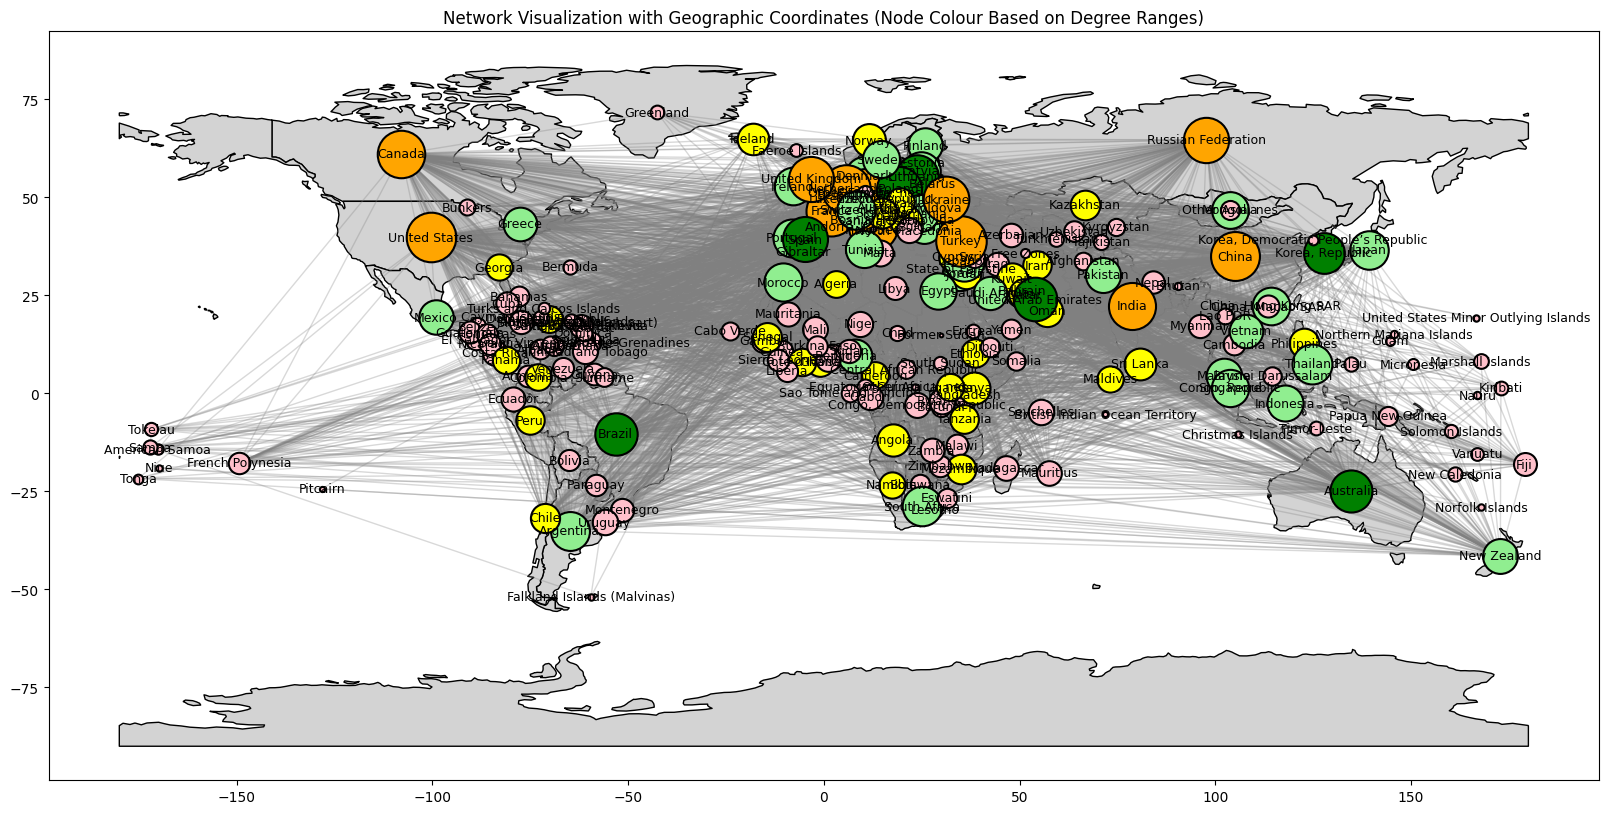

Community 1: frozenset({'Australia', 'Mauritius', 'Mexico', 'Nicaragua', 'New Caledonia', 'Cayman Islands', 'Guyana', 'Greenland', 'Namibia', 'Guinea-Bissau', 'India', 'Saint Vincent and the Grenadines', 'Bahamas', 'Bhutan', 'Colombia', 'Korea, Democratic People’s Republic', 'Yemen', 'Guam', 'Myanmar', 'Netherlands', 'Gibraltar', 'American Samoa', 'Turkey', 'Germany', 'Curacao', 'United States', 'Cuba', 'Indonesia', 'Kiribati', 'Haiti', 'Belize', 'Latin American Integration Association, nes', 'Guatemala', 'Peru', 'Chile', 'Marshall Islands', 'Other Asia, nes', 'Sierra Leone', 'Eswatini', 'Ecuador', 'Fiji', 'Vanuatu', 'Tonga', 'Jamaica', 'Honduras', 'China, Hong Kong SAR', 'Bermuda', 'Saint Pierre and Miquelon', 'Palau', 'Mongolia', 'Malawi', 'Lao PDR', 'Samoa', 'El Salvador', 'Cambodia', 'Solomon Islands', 'Zimbabwe', 'Oceania, nes', 'Burundi', 'Saint Lucia', 'China', 'Bangladesh', 'British Virgin Islands', 'Suriname', 'Brazil', 'Canada', 'Antigua and Barbuda', 'Costa Rica', 'Montserra

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms import community
import geopandas as gpd

# Read the data from CSV files
nodes_df = pd.read_csv('/content/wheet_lat_world.csv')
edges_df = pd.read_csv('/content/data_wheat_world.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    G.add_node(row['Source'], pos=(row['Latitude'], row['Longitude']))

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Calculate node degrees
node_degrees = dict(G.degree())

# Determine nodes to label (degree > 35)
label_nodes = [node for node, degree in node_degrees.items() if degree > 0]

# Plot the network with a world map background
plt.figure(figsize=(30, 28))

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot world map
world.plot(ax=plt.gca(), color='lightgray', edgecolor='black')

# Draw edges with reduced alpha for clarity
for edge in G.edges():
    u, v = edge
    if u in pos and v in pos:  # Check if both nodes have positions
        y1, x1 = pos[u]  # Swap x and y coordinates
        y2, x2 = pos[v]  # Swap x and y coordinates
        plt.plot([x1, x2], [y1, y2], 'gray', alpha=0.3, linewidth=1)  # Reduce alpha for clarity

# Draw nodes with positions, sizes according to degree, and colours based on degree ranges
for node, position in pos.items():
    y, x = position  # Swap x and y coordinates
    node_degree = node_degrees[node]
    node_size = node_degree * 7  # Adjust the multiplier for desired node size
    if node_degree <= 50:
        node_color = 'pink'
    elif node_degree <= 80:
        node_color = 'yellow'
    elif node_degree <= 120:
        node_color = 'lightgreen'
    elif node_degree <= 150:
        node_color = 'green'
    else:
        node_color = 'orange'
    if node in label_nodes:
        plt.scatter(x, y, s=node_size, c=node_color, edgecolors='black', linewidths=1.5, zorder=2)  # Ensure labelled nodes are on top
        plt.text(x, y, node, fontsize=9, ha='center', va='center', zorder=3)  # Add node label
    else:
        plt.scatter(x, y, s=node_size, c=node_color, zorder=1)

plt.title('Network Visualization with Geographic Coordinates (Node Colour Based on Degree Ranges)')
plt.show()

# Find the communities using the greedy modularity method
communities = community.greedy_modularity_communities(G)

# Print the communities
for i, comm in enumerate(communities):
    print(f"Community {i+1}: {comm}")


In [ ]:
import pandas as pd

# Read the data from CSV files
edges_df = pd.read_csv('/content/data_wheat_world.csv')

# Group the data by exporting-importing country pairs and calculate the total trade volume
trade_relationships = edges_df.groupby(['Source', 'Target'])['Weight '].sum().reset_index()

# Sort the trade relationships by trade volume in descending order to find the strongest trade relationships
strongest_relationships = trade_relationships.sort_values(by='Weight ', ascending=False)

# Display the top 10 strongest trade relationships
print("Top 10 Strongest Trade Relationships:")
print(strongest_relationships.head(10))

# Analyse any notable dependencies or interdependencies between the identified pairs
# You can further investigate the trade patterns, geographical proximity, economic factors, etc., to identify dependencies or interdependencies.



Top 10 Strongest Trade Relationships:
                  Source       Target       Weight 
6078  Russian Federation        Egypt  4.671893e+07
6177  Russian Federation       Turkey  3.603195e+07
111            Argentina       Brazil  2.711900e+07
2286              France      Algeria  1.892045e+07
7702             Ukraine        Egypt  1.678875e+07
8178       United States       Mexico  1.633102e+07
1119              Canada        China  1.536687e+07
3812          Kazakhstan   Uzbekistan  1.527091e+07
8202       United States  Philippines  1.462878e+07
2300              France      Belgium  1.362130e+07


In [ ]:
import networkx as nx
import pandas as pd
from networkx.algorithms import community

# Read the data from CSV files
edges_df = pd.read_csv('/content/data_wheat_world.csv')

# Create a new graph object
G = nx.Graph()

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Detect communities using the Louvain method
communities = community.greedy_modularity_communities(G)

# Print the detected communities
print("Detected Communities:")
for i, comm in enumerate(communities):
    print(f"Community {i+1}: {comm}")

# Analyse regional trade patterns
# You can further investigate the trade relationships within each detected community to identify intra-regional trade patterns.
# Additionally, you can visualise the network with nodes coloured by their detected communities to observe distinct clusters.


Detected Communities:
Community 1: frozenset({'Australia', 'Mauritius', 'Mexico', 'Nicaragua', 'New Caledonia', 'Cayman Islands', 'Guyana', 'Greenland', 'Namibia', 'Guinea-Bissau', 'India', 'Saint Vincent and the Grenadines', 'Bahamas', 'Bhutan', 'Colombia', 'Korea, Democratic People’s Republic', 'Yemen', 'Guam', 'Myanmar', 'Netherlands', 'Gibraltar', 'American Samoa', 'Turkey', 'Germany', 'Curacao', 'United States', 'Cuba', 'Indonesia', 'Kiribati', 'Haiti', 'Belize', 'Latin American Integration Association, nes', 'Guatemala', 'Peru', 'Chile', 'Marshall Islands', 'Other Asia, nes', 'Sierra Leone', 'Eswatini', 'Ecuador', 'Fiji', 'Vanuatu', 'Tonga', 'Jamaica', 'Honduras', 'China, Hong Kong SAR', 'Bermuda', 'Saint Pierre and Miquelon', 'Palau', 'Mongolia', 'Malawi', 'Lao PDR', 'Samoa', 'El Salvador', 'Cambodia', 'Solomon Islands', 'Zimbabwe', 'Oceania, nes', 'Burundi', 'Saint Lucia', 'China', 'Bangladesh', 'British Virgin Islands', 'Suriname', 'Brazil', 'Canada', 'Antigua and Barbuda', 'C

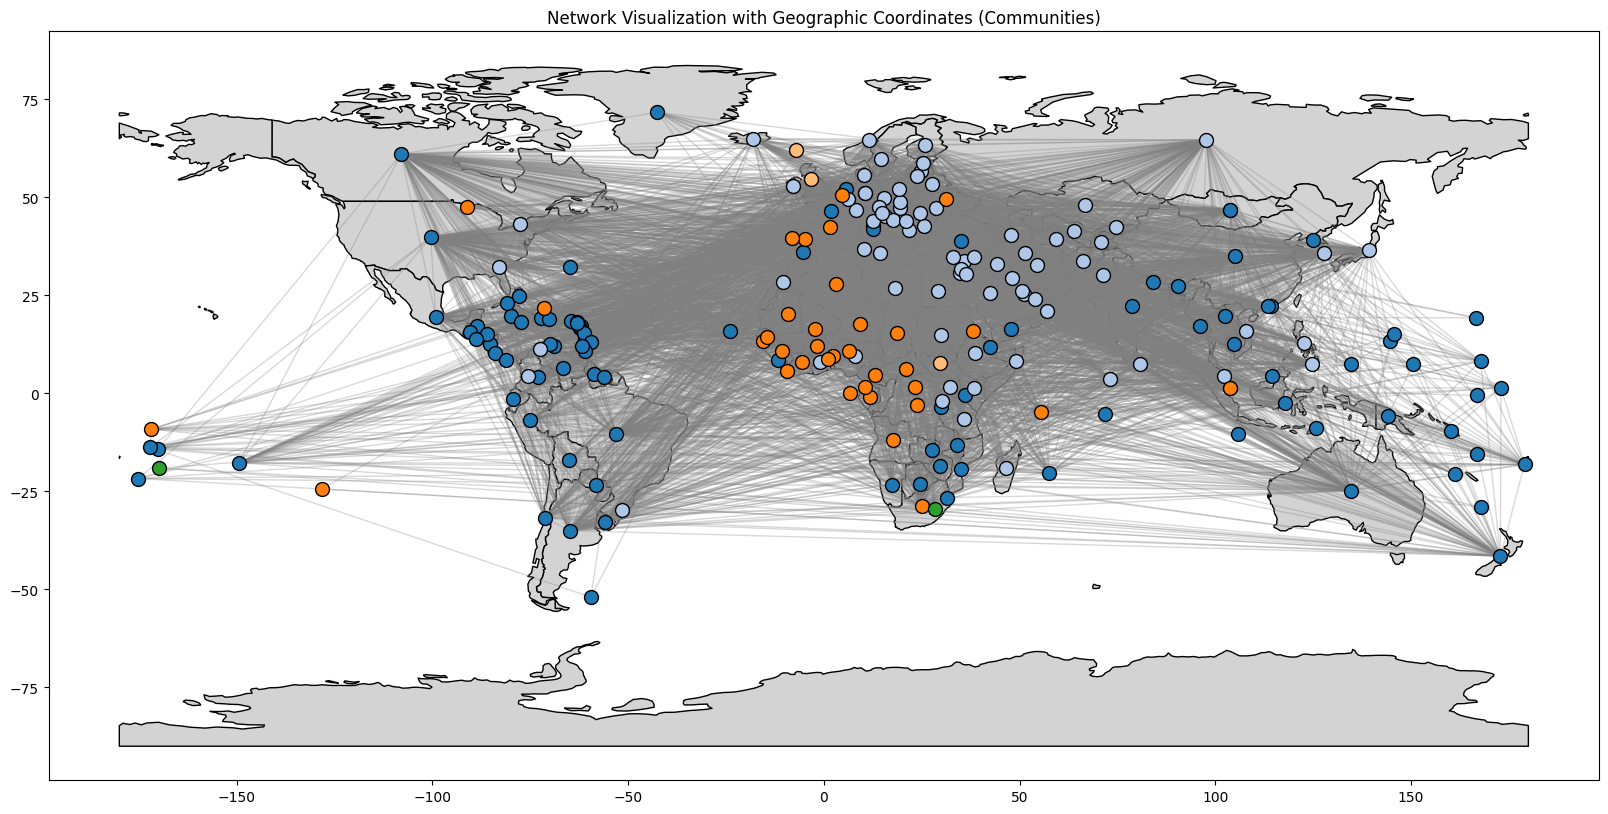

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms import community
import geopandas as gpd

# Read the data from CSV files
nodes_df = pd.read_csv('/content/wheet_lat_world.csv')
edges_df = pd.read_csv('/content/data_wheat_world.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    G.add_node(row['Source'], pos=(row['Latitude'], row['Longitude']))

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Detect communities using the Louvain method
communities = community.greedy_modularity_communities(G)

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Plot the network with a world map background
plt.figure(figsize=(20, 18))

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot world map
world.plot(ax=plt.gca(), color='lightgray', edgecolor='black')

# Draw edges with reduced alpha for clarity
for edge in G.edges():
    u, v = edge
    if u in pos and v in pos:  # Check if both nodes have positions
        y1, x1 = pos[u]  # Swap x and y coordinates
        y2, x2 = pos[v]  # Swap x and y coordinates
        plt.plot([x1, x2], [y1, y2], 'gray', alpha=0.3, linewidth=1)  # Reduce alpha for clarity

# Assign a unique colour to each community
community_colours = plt.cm.tab20.colors[:len(communities)]

# Draw nodes with positions, sizes according to degree, and colours based on their community
for i, comm in enumerate(communities):
    for node in comm:
        if node in pos:  # Check if the node exists in the positions dictionary
            y, x = pos[node]  # Swap x and y coordinates
            node_size = 100
            node_color = community_colours[i]
            plt.scatter(x, y, s=node_size, c=node_color, edgecolors='black', linewidths=1, zorder=2)

plt.title('Network Visualization with Geographic Coordinates (Communities)')
plt.show()


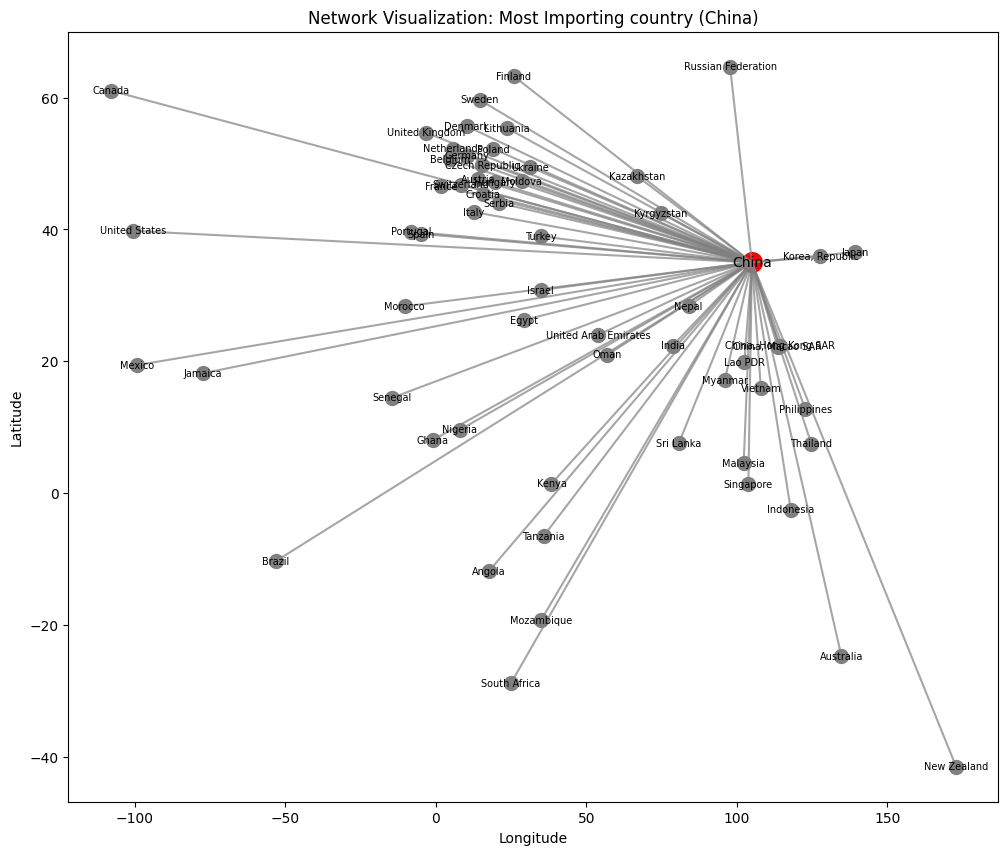

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Read the data from CSV files
nodes_df = pd.read_csv('/content/wheet_lat_world.csv')
edges_df = pd.read_csv('/content/data_wheat_world.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    if row['Source'] not in ['Georgia', 'Other Asia, nes', 'Jordan', 'Lebanon', 'Mongolia', 'Greece']:  # Exclude specified nodes
        G.add_node(row['Source'], pos=(row['Latitude'], row['Longitude']))

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    # Only add edges where China is the target (importing)
    if row['Target'] == 'China':
        G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Get the subgraph consisting only of China and its directly connected nodes
china_subgraph = nx.ego_graph(G, 'China', radius=1, center=True, undirected=False)

# Plot the network with a rotated layout
plt.figure(figsize=(12, 10))  # Adjust figure size for better visualization

# Draw edges between China and its directly connected nodes
for node in china_subgraph.nodes():
    if node != 'China' and node in pos:  # Check if the node exists in pos
        plt.plot([pos[node][1], pos['China'][1]], [pos[node][0], pos['China'][0]], color='gray', alpha=0.7)

# Draw nodes
for node, position in pos.items():
    if node in china_subgraph.nodes() and node in pos:  # Check if the node exists in china_subgraph and pos
        if node == 'China':
            plt.scatter(position[1], position[0], s=200, c='red', label='_')  # Don't show China in the legend
            plt.text(position[1], position[0], node, fontsize=10, ha='center', va='center')  # Label China with larger font size
        else:
            plt.scatter(position[1], position[0], s=100, c='grey', label='_')  # Don't show directly connected nodes in the legend
            plt.text(position[1], position[0], node, fontsize=7, ha='center', va='center')  # Label directly connected nodes with smaller font size

plt.title('Network Visualization: Most Importing country (China)')
plt.xlabel('Longitude')  # Swap x and y labels
plt.ylabel('Latitude')  # Swap x and y labels
plt.show()


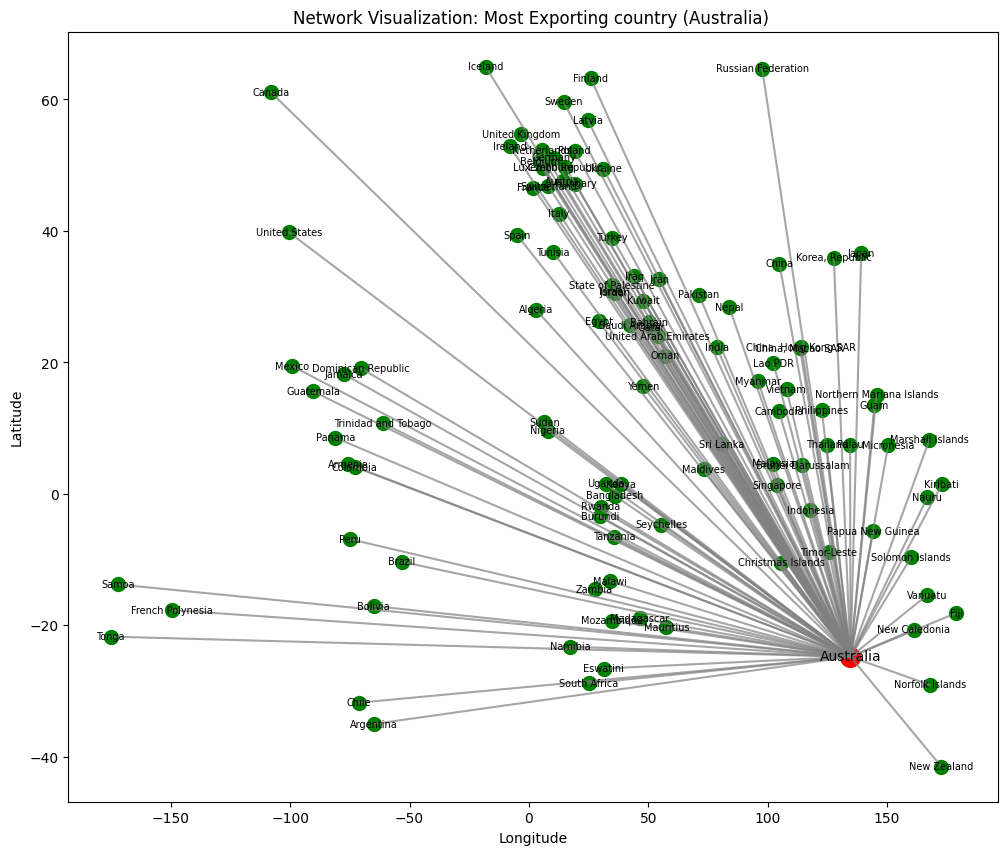

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Read the data from CSV files
nodes_df = pd.read_csv('/content/wheet_lat_world.csv')
edges_df = pd.read_csv('/content/data_wheat_world.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    if row['Source'] not in ['Georgia', 'Other Asia, nes', 'Georgia', 'Lebanon', 'Mongolia']:  # Exclude specified nodes
        G.add_node(row['Source'], pos=(row['Latitude'], row['Longitude']))

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    # Only add edges where Australia is the source (exporting)
    if row['Source'] == 'Australia':
        G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Get the subgraph consisting only of Australia and its directly connected nodes
australia_subgraph = nx.ego_graph(G, 'Australia', radius=1, center=True, undirected=False)

# Plot the network with a rotated layout
plt.figure(figsize=(12, 10))  # Adjust figure size for better visualization

# Draw edges between Australia and its directly connected nodes
for node in australia_subgraph.nodes():
    if node != 'Australia' and node in pos:  # Check if the node exists in pos
        plt.plot([pos['Australia'][1], pos[node][1]], [pos['Australia'][0], pos[node][0]], color='gray', alpha=0.7)

# Draw nodes
for node, position in pos.items():
    if node in australia_subgraph.nodes() and node in pos:  # Check if the node exists in australia_subgraph and pos
        if node == 'Australia':
            plt.scatter(position[1], position[0], s=200, c='red', label='_')  # Don't show Australia in the legend
            plt.text(position[1], position[0], node, fontsize=10, ha='center', va='center')  # Label Australia with larger font size
        else:
            plt.scatter(position[1], position[0], s=100, c='green', label='_')  # Don't show directly connected nodes in the legend
            plt.text(position[1], position[0], node, fontsize=7, ha='center', va='center')  # Label directly connected nodes with smaller font size

plt.title('Network Visualization: Most Exporting country (Australia) ')
plt.xlabel('Longitude')  # Swap x and y labels
plt.ylabel('Latitude')  # Swap x and y labels
plt.show()


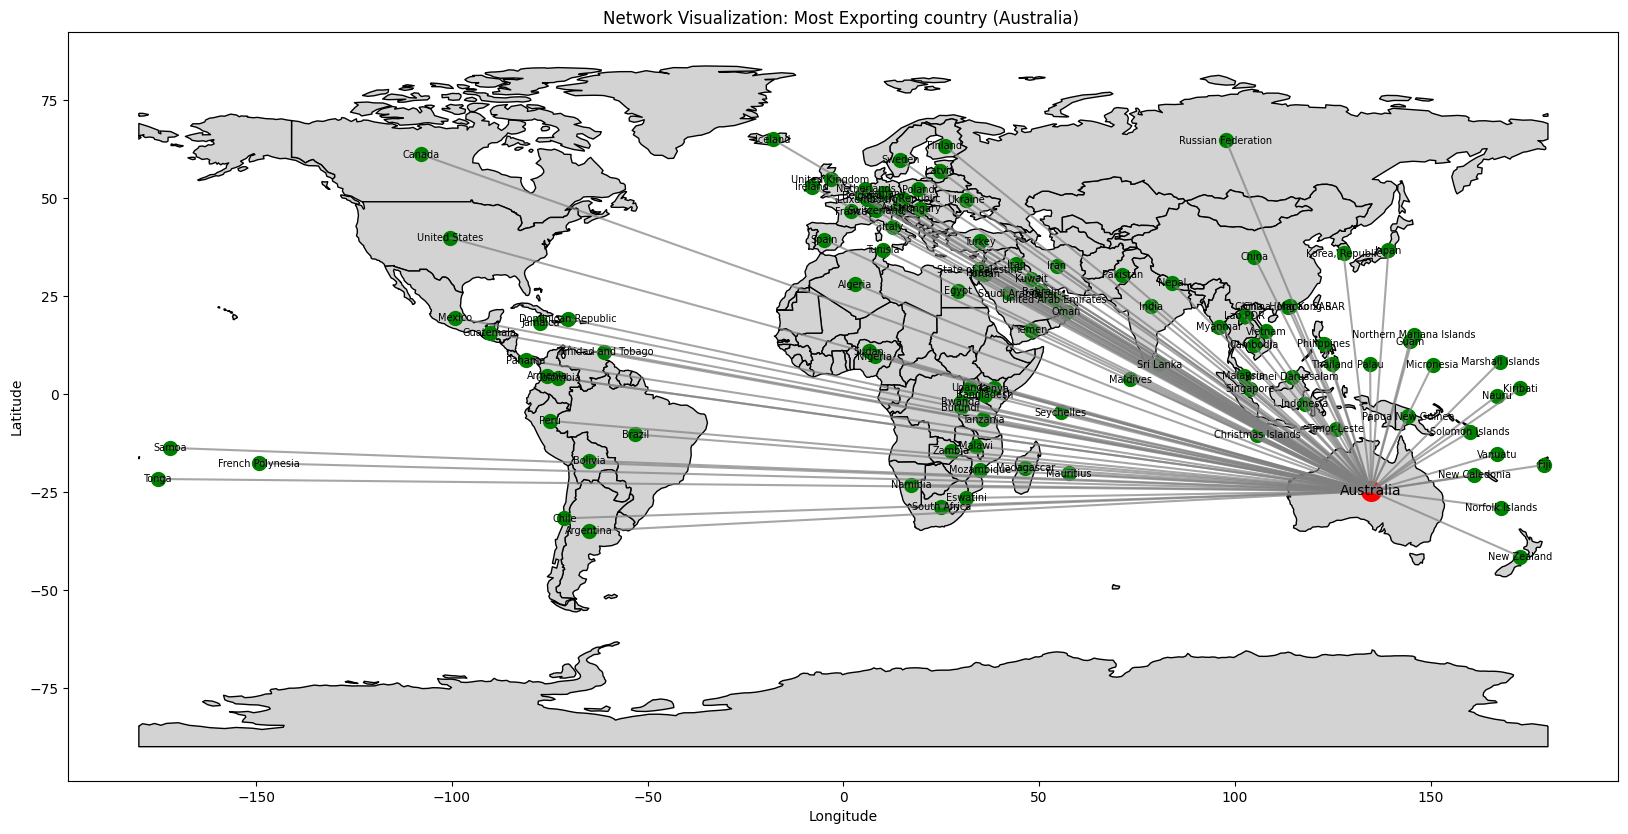

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Read the data from CSV files
nodes_df = pd.read_csv('/content/wheet_lat_world.csv')
edges_df = pd.read_csv('/content/data_wheat_world.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    if row['Source'] not in ['Georgia', 'Other Asia, nes', 'Georgia', 'Lebanon', 'Mongolia']:  # Exclude specified nodes
        G.add_node(row['Source'], pos=(row['Latitude'], row['Longitude']))

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    # Only add edges where Australia is the source (exporting)
    if row['Source'] == 'Australia':
        G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Get the subgraph consisting only of Australia and its directly connected nodes
australia_subgraph = nx.ego_graph(G, 'Australia', radius=1, center=True, undirected=False)

# Plot the network with a rotated layout
plt.figure(figsize=(20, 18))  # Adjust figure size for better visualization

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot world map
world.plot(ax=plt.gca(), color='lightgray', edgecolor='black')

# Draw edges between Australia and its directly connected nodes
for node in australia_subgraph.nodes():
    if node != 'Australia' and node in pos:  # Check if the node exists in pos
        plt.plot([pos['Australia'][1], pos[node][1]], [pos['Australia'][0], pos[node][0]], color='gray', alpha=0.7)

# Draw nodes
for node, position in pos.items():
    if node in australia_subgraph.nodes() and node in pos:  # Check if the node exists in australia_subgraph and pos
        if node == 'Australia':
            plt.scatter(position[1], position[0], s=200, c='red', label='_')  # Don't show Australia in the legend
            plt.text(position[1], position[0], node, fontsize=10, ha='center', va='center')  # Label Australia with larger font size
        else:
            plt.scatter(position[1], position[0], s=100, c='green', label='_')  # Don't show directly connected nodes in the legend
            plt.text(position[1], position[0], node, fontsize=7, ha='center', va='center')  # Label directly connected nodes with smaller font size

plt.title('Network Visualization: Most Exporting country (Australia) ')
plt.xlabel('Longitude')  # Swap x and y labels
plt.ylabel('Latitude')  # Swap x and y labels
plt.show()


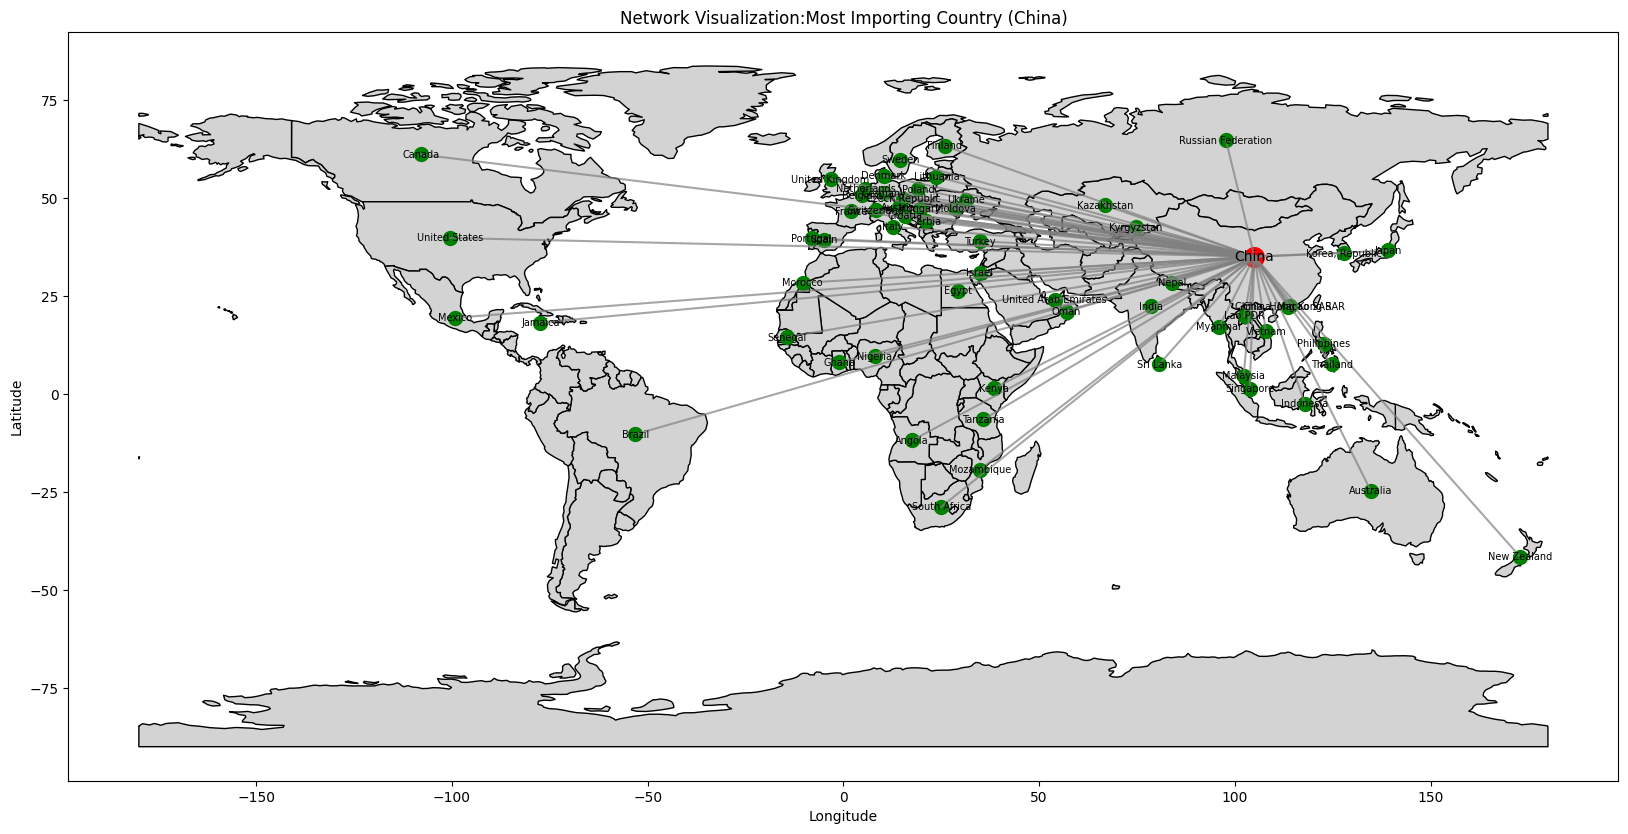

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Read the data from CSV files
nodes_df = pd.read_csv('/content/wheet_lat_world.csv')
edges_df = pd.read_csv('/content/data_wheat_world.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    if row['Source'] not in ['Georgia', 'Other Asia, nes', 'Jordan', 'Lebanon', 'Mongolia', 'Greece']:  # Exclude specified nodes
        G.add_node(row['Source'], pos=(row['Latitude'], row['Longitude']))

# Add edges to the graph with weights
for index, row in edges_df.iterrows():
    # Only add edges where China is the target (importing)
    if row['Target'] == 'China':
        G.add_edge(row['Source'], row['Target'], weight=row['Weight '])

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Get the subgraph consisting only of China and its directly connected nodes
china_subgraph = nx.ego_graph(G, 'China', radius=1, center=True, undirected=False)

# Plot the network with a rotated layout and base map
plt.figure(figsize=(20, 18))  # Adjust figure size for better visualization

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot world map
world.plot(ax=plt.gca(), color='lightgray', edgecolor='black')

# Draw edges between China and its directly connected nodes
for node in china_subgraph.nodes():
    if node != 'China' and node in pos:  # Check if the node exists in pos
        plt.plot([pos[node][1], pos['China'][1]], [pos[node][0], pos['China'][0]], color='gray', alpha=0.7)

# Draw nodes
for node, position in pos.items():
    if node in china_subgraph.nodes() and node in pos:  # Check if the node exists in china_subgraph and pos
        if node == 'China':
            plt.scatter(position[1], position[0], s=200, c='red', label='_')  # Don't show China in the legend
            plt.text(position[1], position[0], node, fontsize=10, ha='center', va='center')  # Label China with larger font size
        else:
            plt.scatter(position[1], position[0], s=100, c='green', label='_')  # Don't show directly connected nodes in the legend
            plt.text(position[1], position[0], node, fontsize=7, ha='center', va='center')  # Label directly connected nodes with smaller font size

plt.title('Network Visualization:Most Importing Country (China)')
plt.xlabel('Longitude')  # Swap x and y labels
plt.ylabel('Latitude')  # Swap x and y labels
plt.show()
